# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import tqdm.notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import SGDRegressor

# Configs

In [2]:
RS = 42
LR = 0.01
EPOCHS = 1000

# Load Diabetes dataset

In [3]:
diabetes = ds.load_diabetes(as_frame=True)
df = diabetes['data']
df.loc[:, "target"] = diabetes["target"]

In [4]:
X, y = diabetes['data'].values, diabetes['target'].values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RS)

In [6]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

# Model Code

In [21]:
class ScratchLinearRegression:
    """
    Linear Regression model with gradient descent.
    """
    def __init__(self, lr=0.01, epochs=100) -> None:
        """
        :param lr: learning rate for gradient descent
        :param epochs: number of epochs for gradient descent
        """
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.loss_history = []
        self.score_history = []
    
    def _init_weights(self, n_features, n_outputs):
        """
        initialize weights randomly
        :param n_features: number of features
        """
        self.weights = np.random.rand(n_features, n_outputs)
        self.weights = np.concatenate([self.weights, np.zeros((1, n_outputs))], axis=0)
    
    def forward(self, x):
        """
        forward function
        :param x: input data
        :return: predicted values
        """
        x_bias = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
        y_hat = x_bias @ self.weights
        return y_hat
        
    def mse(self, y_hat, y):
        """
        mean squared error
        :param y_hat: predicted values
        :param y: true values
        :return: loss value
        """
        return np.mean((y_hat - y) ** 2)
    
    def gradient_descent(self, x, y_hat, y):
        """
        update weights with gradient descent 
        :param x: input data
        :param y_hat: predicted values
        :param y: true values
        """
        x_bias = np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
        grads = 2*(x_bias.T @ (y_hat - y)) / x_bias.shape[0]
        self.weights = self.weights - (self.lr * grads)
    
    def r2_score(self, y_hat, y):
        """
        r2 score
        :param y_hat: predicted values
        :param y: true values
        :return: r2 score
        """
        return 1 - np.sum((y - y_hat)**2) / np.sum((y - y.mean())**2)
    
    def fit(self, x, y):
        """
        fit the model
        :param x: input data
        :param y: true values
        """
        self._init_weights(x.shape[1], y.shape[1])
    
        loop = tqdm.tqdm(range(self.epochs), desc="Training")
        for i in loop:
            y_hat = self.forward(x)
            self.gradient_descent(x, y_hat, y)
            loss = self.mse(y_hat, y)
            score = self.r2_score(y_hat, y)
            self.loss_history.append(loss)
            self.score_history.append(score)
            loop.set_postfix(loss=loss, score=score)
                
    def predict(self, x):
        """
        predict values
        :param x: input data
        :return: predicted values
        """
        y_hat = self.forward(x)
        return y_hat
            

In [22]:
sc_model = ScratchLinearRegression(lr=LR, epochs=EPOCHS)
sc_model.fit(x_train, y_train)
y_hat = sc_model.predict(x_train)
sc_model_loss_hist = sc_model.loss_history
sc_model_score_hist = sc_model.score_history

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
sk_model = SGDRegressor(penalty=None, max_iter=EPOCHS, eta0=LR, learning_rate="constant")
sk_model_loss_hist = []
sk_model_score_hist = []
for e in range(EPOCHS):
    sk_model.partial_fit(x_train, y_train.ravel())
    y_hat = sk_model.predict(x_train)
    sk_model_loss_hist.append(mean_squared_error(y_train.ravel(), y_hat))
    sk_model_score_hist.append(r2_score(y_train.ravel(), y_hat))


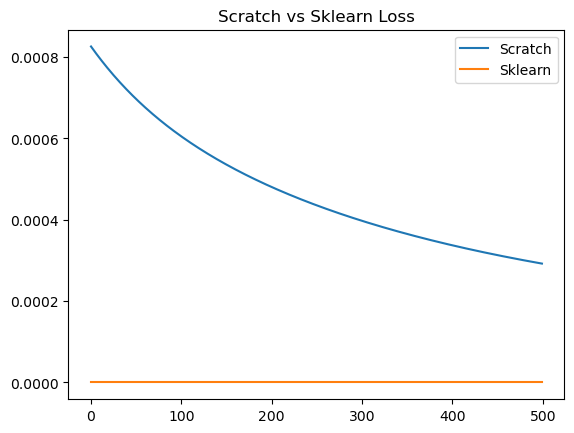

In [30]:
plt.plot(sc_model_loss_hist[500:], label="Scratch")
plt.plot(sk_model_loss_hist[500:], label="Sklearn")
plt.legend()
plt.title("Scratch vs Sklearn Loss")
plt.show()

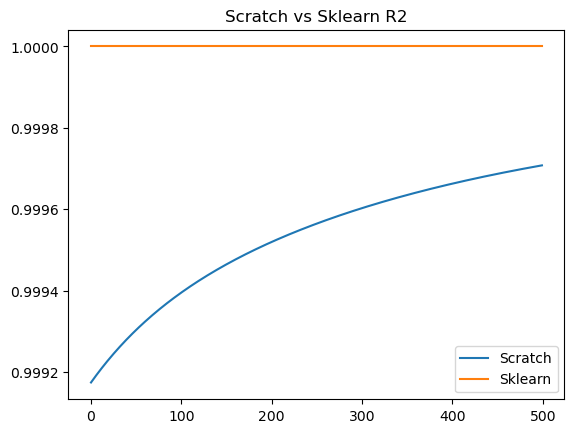

In [31]:
plt.plot(sc_model_score_hist[500:], label="Scratch")
plt.plot(sk_model_score_hist[500:], label="Sklearn")
plt.legend()
plt.title("Scratch vs Sklearn R2")
plt.show()